In [1]:
# auto reload packages and modules when they are modified
%load_ext autoreload
%autoreload 2
# draw matplotlib plots in line
%matplotlib inline
# enforce PEP 8 code on jupyter lab ...
%load_ext lab_black
# ... or jupyter notebook
# %load_ext nb_black

In [2]:
# General
import pandas as pd
import numpy as np

# modelling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import scipy.stats as st

from matplotlib import rcParams
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

import plotly.express as px
import plotly.graph_objects as go

In [3]:
data = pd.read_csv("../data/raw/WA_Fn-UseC_-HR-Employee-Attrition.csv")

In [4]:
# dictionaries for transformation
# Index(['No', 'Yes'], dtype='object', name='Attrition')
att = {"No": 0, "Yes": 1}
data = data.replace({"Attrition": att})
# Index(['Non-Travel', 'Travel_Frequently', 'Travel_Rarely'], dtype='object', name='BusinessTravel')
tra = {"Non-Travel": 0, "Travel_Frequently": 2, "Travel_Rarely": 1}
data = data.replace({"BusinessTravel": tra})
# Index(['Female', 'Male'], dtype='object', name='Gender')
gen = {"Female": 0, "Male": 1}
data = data.replace({"Gender": gen})
# Index(['No', 'Yes'], dtype='object', name='OverTime')
ove = {"No": 0, "Yes": 1}
data = data.replace({"OverTime": ove})

In [5]:
# dropping these because based on histograms they do not bring much information
df = data.drop(
    [
        "DailyRate",
        "EmployeeCount",
        "EmployeeNumber",
        "HourlyRate",
        "MonthlyRate",
        "Over18",
        "StandardHours",
    ],
    axis=1,
).copy(deep=True)

In [6]:
# dummy variables
# https://www.geeksforgeeks.org/how-to-convert-categorical-variable-to-numeric-in-pandas/
# careful about the dummy variable trap! drop one of the columns created with dummy variables

# DEPARTMENT
# Index(['Human Resources', 'Research & Development', 'Sales'], dtype='object', name='Department')
# we are creating columns 'Research & Development', 'Sales' instead, all the others are Human Recources, so we avoid the dummy variable trap
# get the dummies and store it in a variable
dummies = pd.get_dummies(df.Department)

# Concatenate the dummies to original dataframe
merged = pd.concat([df, dummies], axis="columns")

# merged.columns
# drop the values
merged = merged.drop(["Department", "Human Resources"], axis="columns")

# merged.columns

# similarly for
# Index(['Human Resources', 'Life Sciences', 'Marketing', 'Medical', 'Other', 'Technical Degree'], dtype='object', name='EducationField')
dummies2 = pd.get_dummies(df.EducationField)
merged2 = pd.concat([merged, dummies2], axis="columns")
merged2 = merged2.drop(["EducationField", "Other"], axis="columns")

# Index(['Healthcare Representative', 'Human Resources', 'Laboratory Technician','Manager', 'Manufacturing Director', 'Research Director','Research Scientist', 'Sales Executive', 'Sales Representative'],dtype='object', name='JobRole')
dummies3 = pd.get_dummies(df.JobRole)
merged3 = pd.concat([merged2, dummies3], axis="columns")
merged3 = merged3.drop(["JobRole", "Human Resources"], axis="columns")

# Index(['Divorced', 'Married', 'Single'], dtype='object', name='MaritalStatus')
dummies4 = pd.get_dummies(df.MaritalStatus)
merged4 = pd.concat([merged3, dummies4], axis="columns")
merged4 = merged4.drop(["MaritalStatus", "Single"], axis="columns")
merged4

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobSatisfaction,...,Healthcare Representative,Laboratory Technician,Manager,Manufacturing Director,Research Director,Research Scientist,Sales Executive,Sales Representative,Divorced,Married
0,41,1,1,1,2,2,0,3,2,4,...,0,0,0,0,0,0,1,0,0,0
1,49,0,2,8,1,3,1,2,2,2,...,0,0,0,0,0,1,0,0,0,1
2,37,1,1,2,2,4,1,2,1,3,...,0,1,0,0,0,0,0,0,0,0
3,33,0,2,3,4,4,0,3,1,3,...,0,0,0,0,0,1,0,0,0,1
4,27,0,1,2,1,1,1,3,1,2,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,0,2,23,2,3,1,4,2,4,...,0,1,0,0,0,0,0,0,0,1
1466,39,0,1,6,1,4,1,2,3,1,...,1,0,0,0,0,0,0,0,0,1
1467,27,0,1,4,3,2,1,4,2,2,...,0,0,0,1,0,0,0,0,0,1
1468,49,0,2,2,3,4,1,2,2,2,...,0,0,0,0,0,0,1,0,0,1


In [7]:
clean_df = merged4.copy(deep=True)

In [48]:
train_df = clean_df.sample(frac=0.9, random_state=97411)
test_df = clean_df.drop(train_df.index)

In [49]:
# trying regression with all the variables
Y_train = train_df["Attrition"]
X_train = train_df.drop(columns="Attrition")
X_train = sm.add_constant(X_train)
glm_binom = sm.GLM(Y_train, X_train, family=sm.families.Binomial())
results_train = glm_binom.fit()

In [10]:
results_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Attrition   No. Observations:                 1323
Model:                            GLM   Df Residuals:                     1283
Model Family:                Binomial   Df Model:                           39
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -386.30
Date:                Fri, 16 Sep 2022   Deviance:                       772.60
Time:                        11:57:56   Pearson chi2:                 2.35e+03
No. Iterations:                    21   Pseudo R-squ. (CS):             0.2488
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         4.2603      1.401      3.040      0.002       1.514       7.007
Age                          -0.0355      0.015     -2.426      0.015      -0.064      -0.007
BusinessTravel                0.8726      0.182      4.782      0.000       0.515       1.230
DistanceFromHome              0.0435      0.011      3.810      0.000       0.021       0.066
Education                     0.0004      0.093      0.005      0.996      -0.182       0.183
EnvironmentSatisfaction      -0.4282      0.087     -4.896      0.000      -0.600      -0.257
Gender                        0.3717      0.195      1.911      0.056      -0.010       0.753
JobInvolvement               -0.5352      0.128     -4.187      0.000      -0.786      -0.285
JobLevel                     -0.1306      0.330     -0.396      0.692      -0.777       0.515
JobSatisfaction              -0.4011      0.086     -4.659      0.000      -0.570      -0.232
MonthlyIncome              2.747e-05   8.45e-05      0.325      0.745      -0.000       0.000
NumCompaniesWorked            0.1847      0.041      4.515      0.000       0.105       0.265
OverTime                      1.8800      0.202      9.290      0.000       1.483       2.277
PercentSalaryHike            -0.0146      0.041     -0.360      0.719      -0.094       0.065
PerformanceRating             0.0557      0.416      0.134      0.894      -0.760       0.871
RelationshipSatisfaction     -0.2714      0.086     -3.142      0.002      -0.441      -0.102
StockOptionLevel             -0.2598      0.167     -1.555      0.120      -0.587       0.068
TotalWorkingYears            -0.0409      0.031     -1.340      0.180      -0.101       0.019
TrainingTimesLastYear        -0.2133      0.078     -2.718      0.007      -0.367      -0.060
WorkLifeBalance              -0.2988      0.131     -2.287      0.022      -0.555      -0.043
YearsAtCompany                0.0763      0.040      1.910      0.056      -0.002       0.155
YearsInCurrentRole           -0.1630      0.048     -3.419      0.001      -0.256      -0.070
YearsSinceLastPromotion       0.1873      0.044      4.221      0.000       0.100       0.274
YearsWithCurrManager         -0.1379      0.050     -2.784      0.005      -0.235      -0.041
Research & Development       18.9646   1.54e+04      0.001      0.999   -3.02e+04    3.03e+04
Sales                        18.7906   1.54e+04      0.001      0.999   -3.02e+04    3.03e+04
Life Sciences                -0.0951      0.393     -0.242      0.809      -0.865       0.675
Marketing                     0.3993      0.485      0.823      0.410      -0.551       1.350
Medical                      -0.1581      0.399     -0.397      0.692      -0.939       0.623
Technical Degree              0.7527      0.459      1.640      0.101      

In [50]:
# testing variables
Y_test = test_df["Attrition"]
X_test = test_df.drop(columns="Attrition")
X_test = sm.add_constant(X_test)
n = len(Y_test)

In [51]:
# this gives probability of attrition
prob_pred = results_train.predict(X_test)

In [52]:
# predictions based on the treshold
def predictions(results, treshold):
    return [1 if x > treshold else 0 for x in results]

In [53]:
levels = np.arange(0, 1.05, 0.05)

In [15]:
levels

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [54]:
confusion_matrix(Y_test, predictions(prob_pred, 0.5))

array([[132,   1],
       [  7,   7]], dtype=int64)

In [17]:
a, b = confusion_matrix(Y_test, predictions(prob_pred, 0.5))

In [18]:
a.sum()

118

In [59]:
confusion_matrix(Y_test, predictions(prob_pred, 0.3))

array([[124,   9],
       [  2,  12]], dtype=int64)

In [55]:
attr_corect_ef = []
stay_corect_ef = []
attr_but_stayed_ef = []
stay_but_attr_ef = []


for l in levels:
    a, b = confusion_matrix(Y_test, predictions(prob_pred, l))
    attr_corect_ef.append(b[1] / b.sum())
    stay_corect_ef.append(a[0] / a.sum())
    if (a[1] + b[1]) == 0:
        attr_but_stayed_ef.append(np.nan)
    else:
        attr_but_stayed_ef.append(a[1] / (a[1] + b[1]))
    if (a[0] + b[0]) == 0:
        stay_but_attr_ef.append(np.nan)
    else:
        stay_but_attr_ef.append(b[0] / (a[0] + b[0]))

In [71]:
# dataframe for the confution matrix info for different levels
confution = pd.DataFrame(
    {
        "Correctly predicted attrition": attr_corect_ef,
        "Correctly predicted staying": stay_corect_ef,
        "Incorrectly predicted staying": stay_but_attr_ef,
        "Incorrectly predicted attrition": attr_but_stayed_ef,
    },
    index=levels,
)

In [72]:
confution.to_csv("fancy_graph.csv")

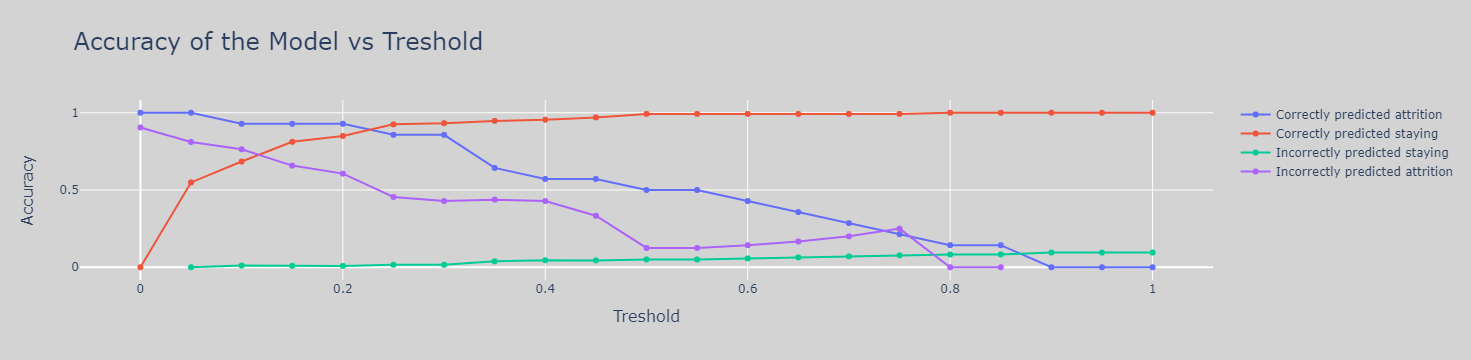

In [69]:
# plotting what does the treshold do?
fig = go.Figure()
for col in confution.columns:
    fig.add_trace(
        go.Scatter(x=confution.index, y=confution[col], mode="lines+markers", name=col)
    )
fig.update_layout(hovermode="x unified")

fig.update_layout(
    title={"text": "Accuracy of the Model vs Treshold", "font": {"size": 24}},
    xaxis={"title": {"text": "Treshold", "font": {"size": 16}}},
    yaxis={"title": {"text": "Accuracy", "font": {"size": 16}}},
    paper_bgcolor="lightgrey",
    plot_bgcolor="lightgrey",
)

fig.show()

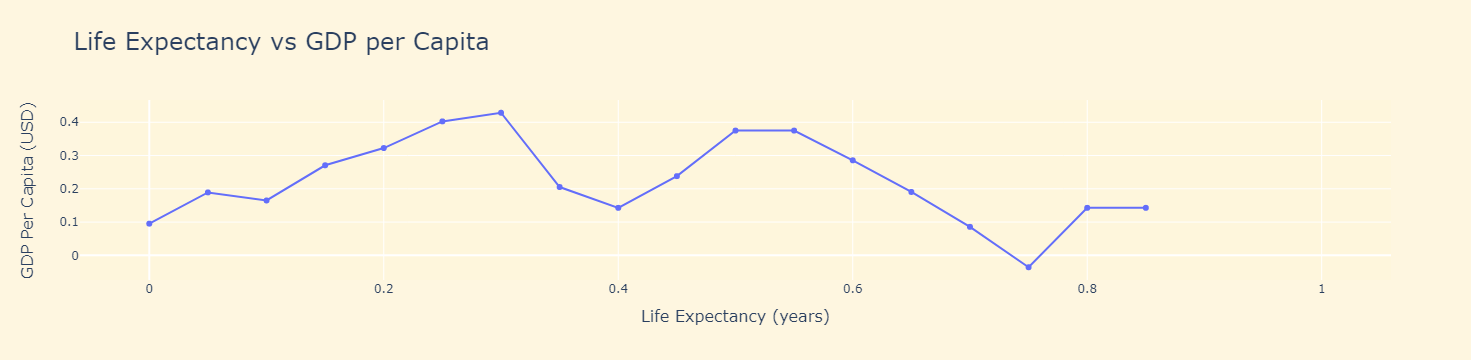

In [64]:
# optimizing to spend money on the people who are actually going to leave
# highest correctly predicted attrition
# lowest incorrectly predicted attrition = if this error is high, we spend money on people who are stying anyway
# lowest incorrectly predicted staying = this one is overall pretty low because of our data set

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=confution.index,
        y=confution["Correctly predicted attrition"]
        - confution["Incorrectly predicted attrition"],
        mode="lines+markers",
    )
)
fig.update_layout(
    title={"text": "Life Expectancy vs GDP per Capita", "font": {"size": 24}},
    xaxis={"title": {"text": "Life Expectancy (years)", "font": {"size": 16}}},
    yaxis={"title": {"text": "GDP Per Capita (USD)", "font": {"size": 16}}},
    paper_bgcolor="rgb(254, 246, 224)",
    plot_bgcolor="rgb(254, 246, 220)",
)

fig.show()

In [33]:
confution["diff"] = (
    confution["Correctly predicted attrition"]
    - confution["Incorrectly predicted attrition"]
)

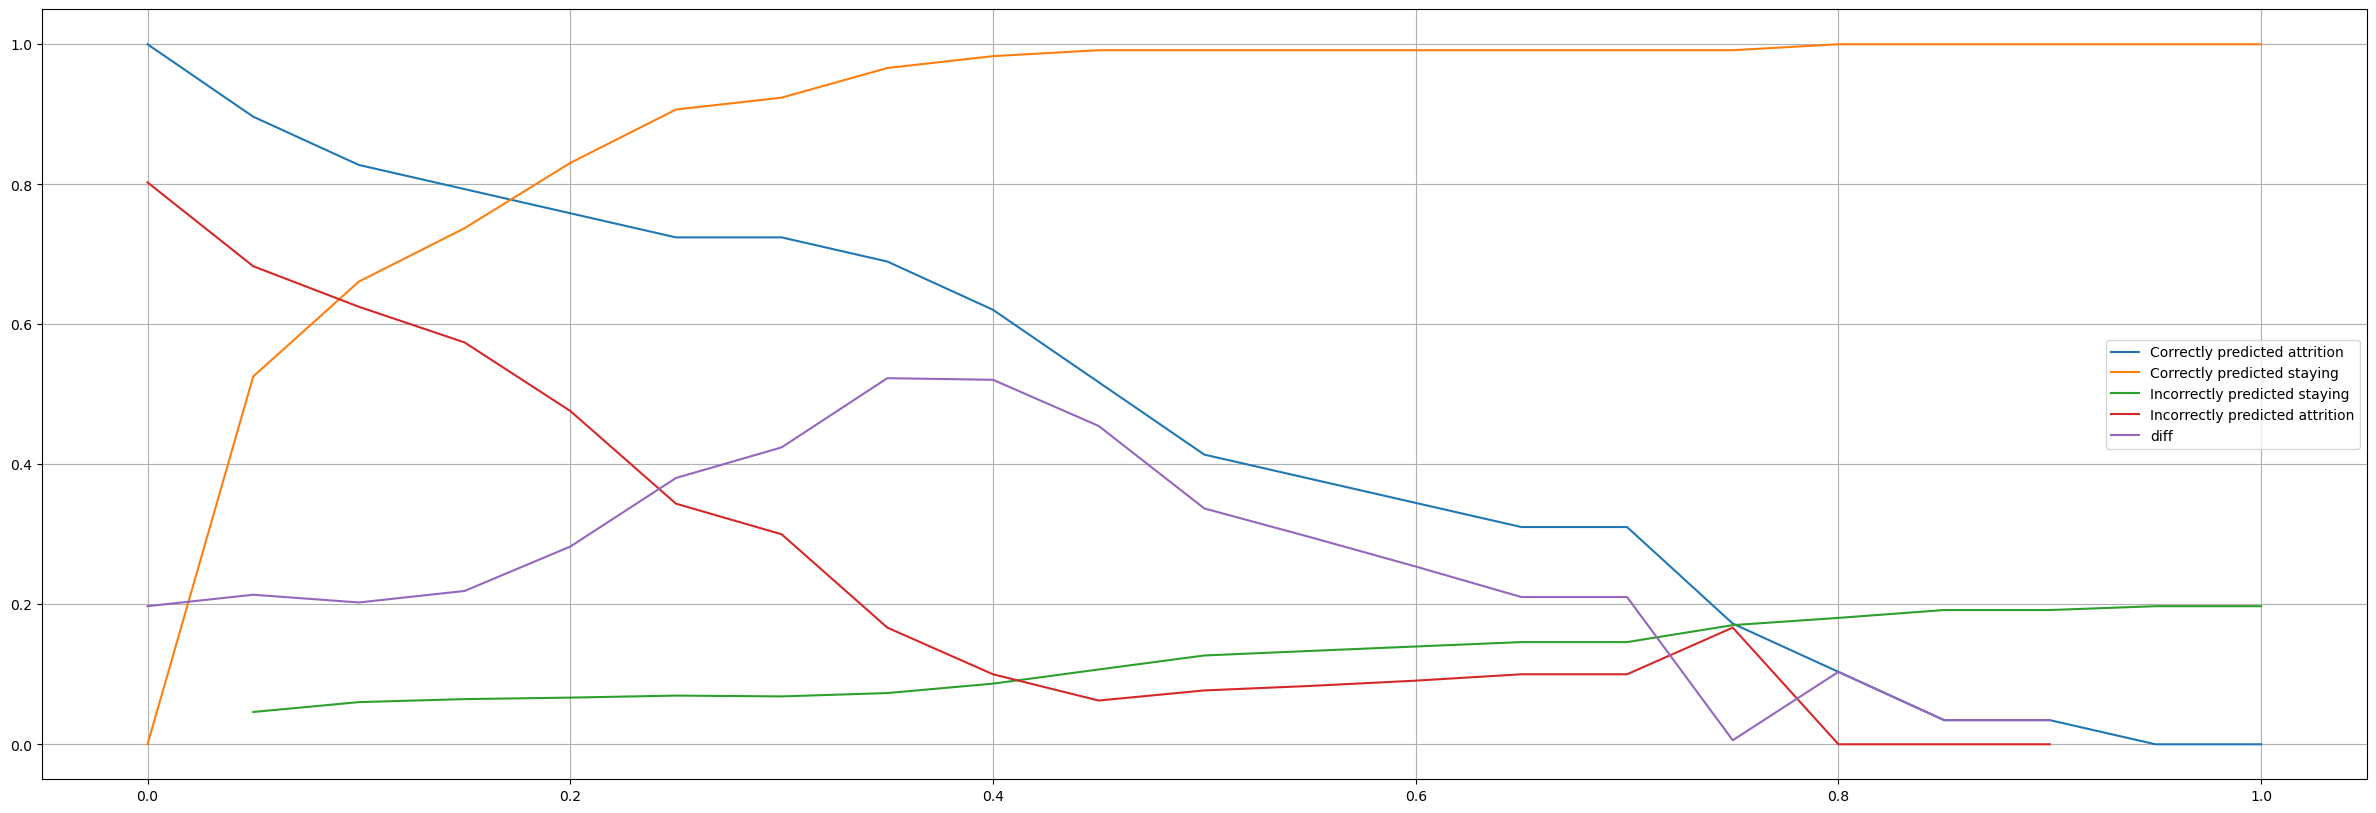

In [47]:
# plotting matplotlib
fig = confution.plot(figsize=(30, 10), grid=True)
plt.savefig("./graphs/output.png")

In [30]:
#!pip install -U kaleido

In [29]:
# fig.write_image("graphs/fig1.png")